In [6]:
import os
get_processed_data_script_file = os.path.join(os.path.pardir,'src','data','get_processed_data.py')

In [15]:
%%writefile $get_processed_data_script_file
import numpy as np
import pandas as pd
import os
# we will use writefile magic function to write the content to the file


def read_data():
    #set the path of raw data
    raw_data_path = os.path.join(os.path.pardir,'project\\titanic','data','raw')
    train_file_path = os.path.join(raw_data_path,'train.csv')
    test_file_path = os.path.join(raw_data_path,'test.csv')
    # read the data with all default parameters
    train_df = pd.read_csv(train_file_path,index_col='PassengerId')
    test_df = pd.read_csv(test_file_path,index_col='PassengerId')
    test_df['Survived'] = -888
    df = pd.concat((train_df,test_df),axis=0)
    return df

# note : to create a feature:assign 
# to apply a fn to dataframe: pipe
def process_data(df):
    # using the method chaining concept
    return (df
            # create title attribute- then add this
            # here x is dataframe df
            .assign(Title = lambda x: x.Name.map(get_title))
            # working missing values - start with this
            .pipe(fill_missing_values)
            # create fare bin feature
            .assign(Fare_bin = lambda x:pd.qcut(x.Fare,4, labels=['very_low','low','high','very_high']))
            # create age state
            .assign(AgeState = lambda x : np.where(x.Age >=18,'Adult','Child'))
            .assign(FamilySize = lambda x : x.Parch + x.SibSp +1)
            .assign(IsMother = lambda x: np.where(((x.Sex == 'female')&(x.Parch>0)&(x.Age>18)&(x.Title!='Miss')),1,0))
            # create deck feature
            .assign(Cabin = lambda x: np.where(x.Cabin == 'T', np.nan, x.Cabin))
            .assign(Deck = lambda x : x.Cabin.map(get_deck))
            #feature Encoding
            .assign(IsMale = lambda x : np.where(x.Sex == 'male',1,0))
            .pipe(pd.get_dummies, columns=['Deck','Pclass','Title','Fare_bin','Embarked','AgeState'])
            #add code to drop unnecessary columns
            # we do not need iplace property bcz we are using method chaining approach
            .drop(['Cabin','Name','Ticket','Parch','SibSp','Sex'],axis=1)
            # reorder columns
            .pipe(reorder_columns)
           )


def reorder_columns(df):
    columns = [column for column in df.columns if column!='Survived']
    columns = ['Survived'] + columns
    df = df[columns]
    return df

    
def get_deck(cabin):
    return np.where(pd.notnull(cabin),str(cabin)[0].upper(),'Z')

def get_title(name):
    title_group = {'mr':'Mr',
                   'mrs':'Mrs',
                   'miss':'Miss',
                   'master':'Master',
                   'don':'Sir',
                   'rev':'Sir',
                   'dr':'Officer',
                   'mme':'Mrs',
                   'ms':'Mrs',
                   'major':'Officer',
                   'lady':'Lady',
                   'sir':'Sir',
                   'mlle':'Miss',
                   'col':'Officer',
                   'capt':'Officer',
                   'the countess':'Lady',
                   'jonkheer':'Sir',
                   'dona':'Lady'
                  }
    first_name_with_title = name.split(',')[1]
    title = first_name_with_title.split('.')[0]
    title = title.strip().lower()
    return title_group[title]

def fill_missing_values(df):
    #embarked
    df.Embarked.fillna('C',inplace=True)
    # fare
    median_fare = df[(df.Pclass == 3) & (df.Embarked == 'S')]['Fare'].median()
    df.Fare.fillna(median_fare,inplace = True)
    # age
    title_age_median = df.groupby('Title').Age.transform('median')
    df.Age.fillna(title_age_median, inplace = True)
    return df

def write_data(df):
    processed_data_path = os.path.join(os.path.pardir,'project\\titanic','data','processed')
    write_train_path = os.path.join(processed_data_path,'train.csv')
    write_test_path = os.path.join(processed_data_path,'test.csv')
    # train data
    df[df.Survived != -888].to_csv(write_train_path)
    #test data
    columns = [column for column in df.columns if column!='Survived']
    df[df.Survived == -888][columns].to_csv(write_test_path)
    
if __name__ == '__main__':
    df = read_data()
    df = process_data(df)
    write_data(df)

Writing ..\project\titanic\src\data\get_processed_data.py


In [16]:
!python $get_processed_data_script_file

In [21]:
import pandas as pd
processed_data_path = os.path.join(os.path.pardir,'project\\titanic','data','processed')
write_train_path = os.path.join(processed_data_path,'train.csv')
write_test_path = os.path.join(processed_data_path,'test.csv')

train_df = pd.read_csv(write_train_path)
test_df = pd.read_csv(write_test_path)
df = pd.concat((train_df,test_df),axis=0)

## Advanced Visualization using Matplotlib

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
# to see the visualization in the notebook itself

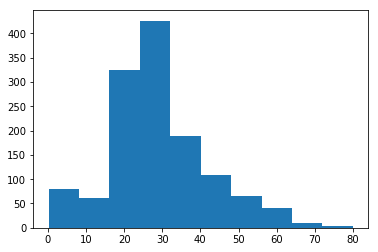

In [27]:
plt.hist(df.Age)
plt.show() # to hide extra array info

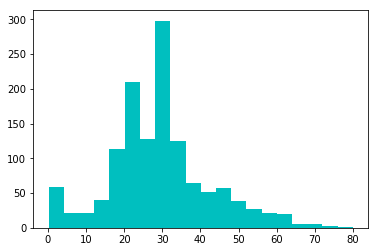

In [30]:
plt.hist(df.Age, bins=20 , color='c')
plt.show()

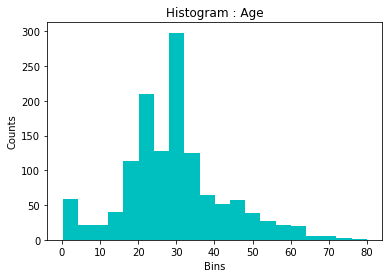

In [31]:
plt.hist(df.Age, bins=20, color='c')
plt.title('Histogram : Age')
plt.xlabel('Bins')
plt.ylabel('Counts')
plt.show()

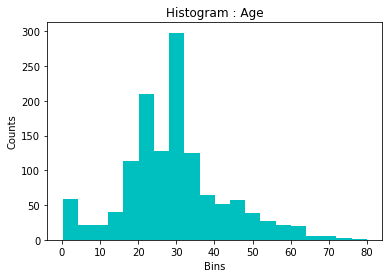

In [32]:
# another way to create the same plot is to use axis object explicitly
# adv is that we can get subplots
# ex. 1 - One subplot only
figureObj, axisObj = plt.subplots()
axisObj.hist(df.Age, bins=20, color='c')
axisObj.set_title('Histogram : Age')
axisObj.set_xlabel('Bins')
axisObj.set_ylabel('Counts')
plt.show()

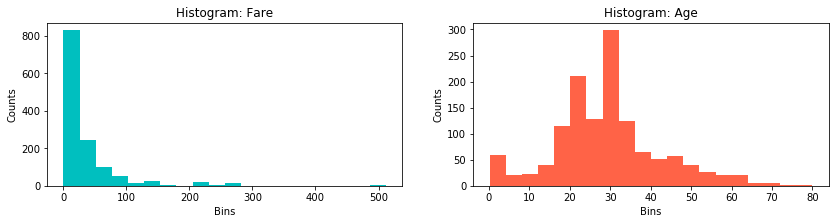

In [35]:
# ex2. Two subplots
# 1,2 : 1 is number of rows and 2 is number of columns
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(14,3))

ax1.hist(df.Fare, bins=20, color='c')
ax1.set_title('Histogram: Fare')
ax1.set_xlabel('Bins')
ax1.set_ylabel('Counts')

ax2.hist(df.Age, bins=20, color='tomato')
ax2.set_title('Histogram: Age')
ax2.set_xlabel('Bins')
ax2.set_ylabel('Counts')

plt.show()

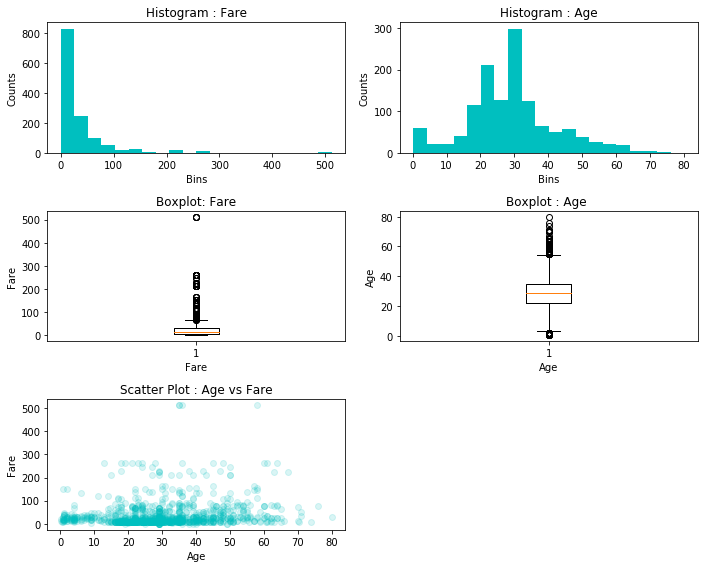

In [49]:
# we can also use axis array instead of individual axis
# axis axis object using ax_array[0,1] ie. 2-D indexing
fig, ax_array = plt.subplots(3,2, figsize=(10,8))

#Plot 1
ax_array[0,0].hist(df.Fare, bins=20, color='c')
ax_array[0,0].set_title('Histogram : Fare')
ax_array[0,0].set_xlabel('Bins')
ax_array[0,0].set_ylabel('Counts')

#Plot 2
ax_array[0,1].hist(df.Age, bins=20, color='c')
ax_array[0,1].set_title('Histogram : Age')
ax_array[0,1].set_xlabel('Bins')
ax_array[0,1].set_ylabel('Counts')

#Plot 3
ax_array[1,0].boxplot(df.Fare.values)
ax_array[1,0].set_title('Boxplot: Fare')
ax_array[1,0].set_xlabel('Fare')
ax_array[1,0].set_ylabel('Fare')

#Plot 4
ax_array[1,1].boxplot(df.Age.values)
ax_array[1,1].set_title('Boxplot : Age ')
ax_array[1,1].set_xlabel('Age')
ax_array[1,1].set_ylabel('Age')

#Plot 5 : scatter plot
ax_array[2,0].scatter(df.Age,df.Fare, color='c', alpha=0.15)
ax_array[2,0].set_title('Scatter Plot : Age vs Fare')
ax_array[2,0].set_xlabel('Age')
ax_array[2,0].set_ylabel('Fare')

ax_array[2,1].axis("off")

plt.tight_layout()
#adjust the plot with some padding

plt.show()

{'boxes': [<matplotlib.lines.Line2D at 0x2420d905048>],
 'caps': [<matplotlib.lines.Line2D at 0x2420d9004e0>,
 'fliers': [<matplotlib.lines.Line2D at 0x2420d8fbeb8>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x2420d919cf8>],
 'whiskers': [<matplotlib.lines.Line2D at 0x2420d905da0>,
  <matplotlib.lines.Line2D at 0x2420d900470>]}

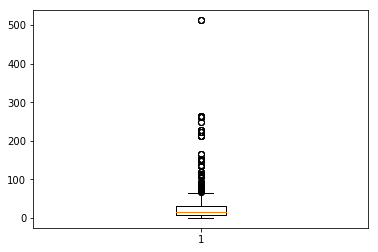